In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from unc_tools import Hyper, UncRegression
from copy import deepcopy
import uncertainties as unc
import os


SAVE_DIR = "/home/yaroslav/vzlet_vault/Практикум/геткат/"
def savefig(name, path= "", fig=None, bbox_inches = None, **kwargs):
    os.makedirs(SAVE_DIR, exist_ok=True)
    if bbox_inches is None:
        bbox_inches = "tight"
    if fig is None:
        fig = plt.gcf()
    new_path = os.path.join(SAVE_DIR, name)
    fig.savefig(new_path, bbox_inches = bbox_inches, **kwargs)
    fig.savefig(os.path.join(".", path, name), bbox_inches = bbox_inches, **kwargs)
    #print(f"Saved: {path}")

def nested_array_to_ufloat(arrays):

    new_array = []
    
    for array in arrays:
        if len(array) == 1:
            new_array.append(array[0])
        else:
            val = unc.ufloat(np.mean(array), np.std(array, ddof = 1))
            new_array.append(val)

    return np.array(new_array)

def separate_unc(df):
    new_df = pd.DataFrame({})
    
    for name in df:
        
        has_unc = any(isinstance(x, unc.core.Variable) or isinstance(x, unc.core.AffineScalarFunc) for x in df[name].to_numpy())

        if has_unc:
            new_df[f"{name}_nom"] = unc.unumpy.nominal_values(df[name])
            new_df[f"{name}_std"] = unc.unumpy.std_devs(df[name])
        else:
            new_df[name] = df[name]

    return new_df

UncRegression.latex_style(True)

In [11]:
DF = pd.DataFrame({"m": [unc.ufloat(0.0103,0.0001), unc.ufloat(0.0204, 0.0001), unc.ufloat(0.0302,0.0001)]})
DF = pd.DataFrame({"m": [0.01,0.02,0.03]})

Pt = 195.08
w = 0.0067

T = 26 + 273.15
C = 0.16
V = 20/1000
p=1.016*101.325

DF["n"] = DF.m * w / Pt

df1 = {"time": np.concat(([1*60+12],np.arange(2,16,1)*60)),
      "V": [4,5,6,6.8,7.4,8,8.6, 9.2, 9.8, 10.4, 10.8, 11.5, 11.9, 12.4, 12.8]}
df1 = pd.DataFrame(df1)

df2 = {"time": np.concat((np.arange(30,600,30), np.arange(600,901,60)), axis = 0),
      "V": [3.4, 4.8, 5.6, 6, 6.8, 7.2, 8, 8.4, 9, 9.6, 10.2, 10.6, 11, 11.4, 11.8, 12.2, 12.6, 13., 13.6, 14., 14.6, 15.2, 16, 16.6, 17.2]}
df2 = pd.DataFrame(df2)

df3 = {"time": df2.time,
      "V": [5.8, 7.4, 8.4, 9.4, 10.8, 11.8, 12.4, 13.4, 14.4, 15, 15.8, 16.6, 17.2, 17.8, 18.4, 19.2, 19.8, 20.4, 21, 21.6, 22.6, 23.6, 24.6, 25.6, 26.5]}
df3 = pd.DataFrame(df3)


dfs = [df1, df2, df3]


In [12]:
from tabulate import tabulate

for df in dfs:
    print()
    print(tabulate(df, tablefmt = "github", headers =["n", "Время, с", "V, мл"]))
    


|   n |   Время, с |   V, мл |
|-----|------------|---------|
|   0 |         72 |     4   |
|   1 |        120 |     5   |
|   2 |        180 |     6   |
|   3 |        240 |     6.8 |
|   4 |        300 |     7.4 |
|   5 |        360 |     8   |
|   6 |        420 |     8.6 |
|   7 |        480 |     9.2 |
|   8 |        540 |     9.8 |
|   9 |        600 |    10.4 |
|  10 |        660 |    10.8 |
|  11 |        720 |    11.5 |
|  12 |        780 |    11.9 |
|  13 |        840 |    12.4 |
|  14 |        900 |    12.8 |

|   n |   Время, с |   V, мл |
|-----|------------|---------|
|   0 |         30 |     3.4 |
|   1 |         60 |     4.8 |
|   2 |         90 |     5.6 |
|   3 |        120 |     6   |
|   4 |        150 |     6.8 |
|   5 |        180 |     7.2 |
|   6 |        210 |     8   |
|   7 |        240 |     8.4 |
|   8 |        270 |     9   |
|   9 |        300 |     9.6 |
|  10 |        330 |    10.2 |
|  11 |        360 |    10.6 |
|  12 |        390 |    11   |
|  13 

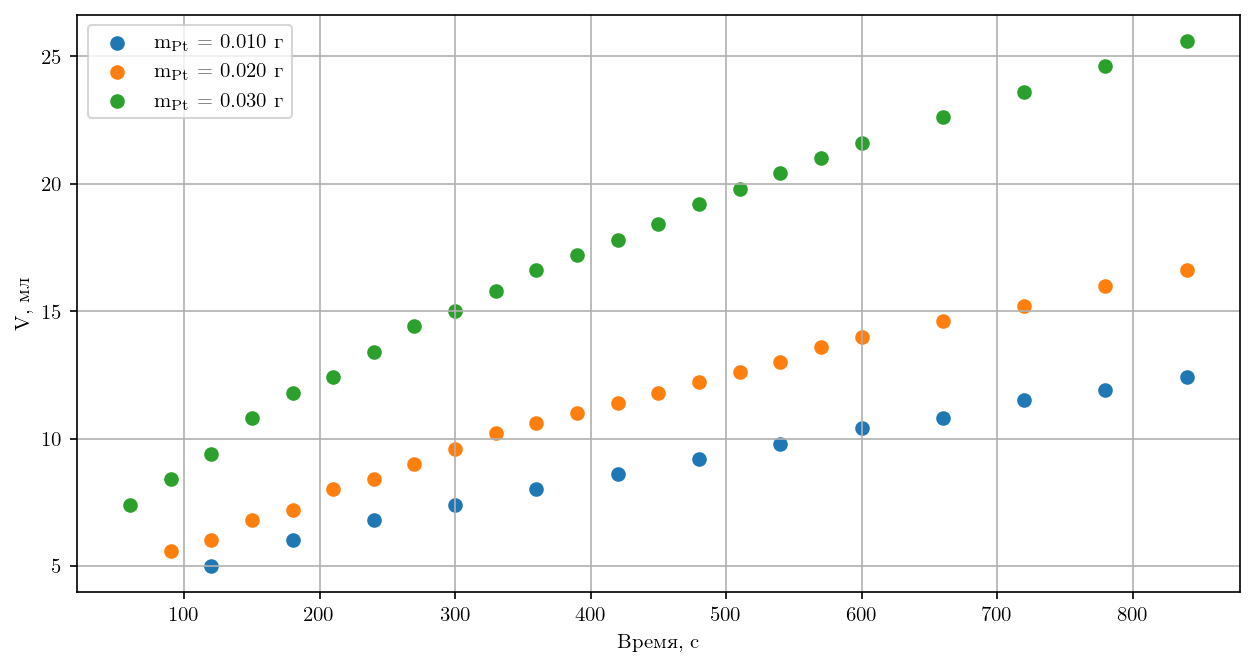

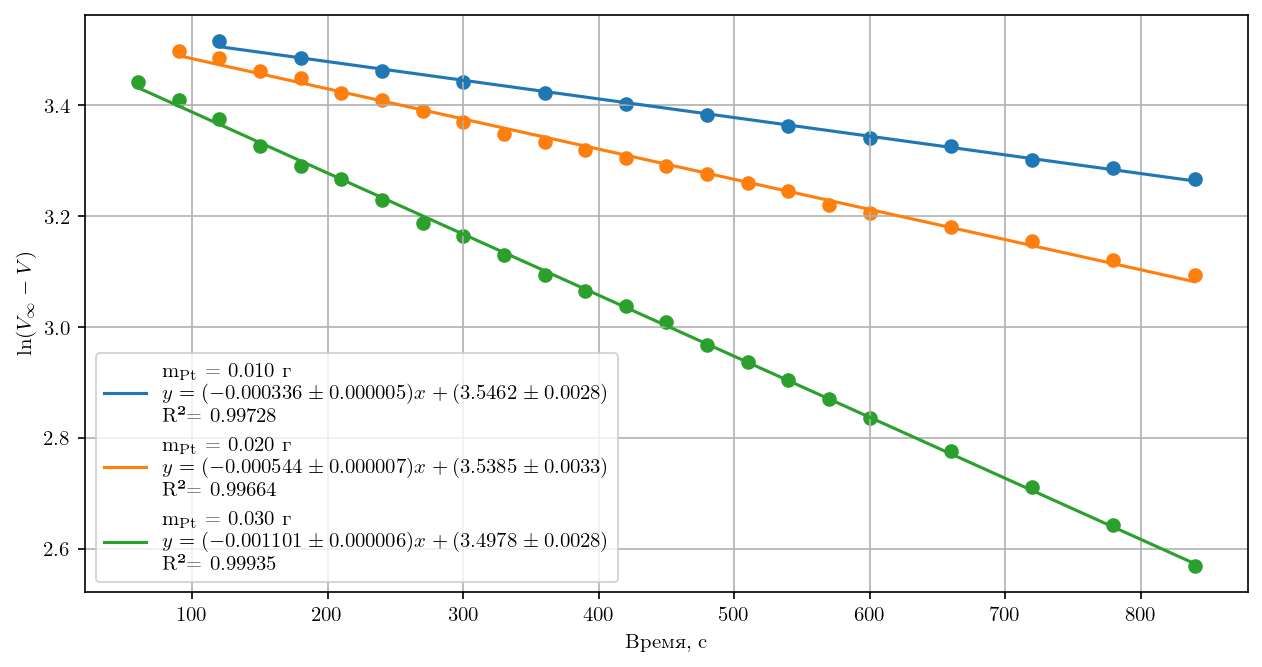

In [13]:
V_inf = C * V * 8.314 * T / (2*p) * 1000

fig1, ax1 = plt.subplots(figsize=(10,5), dpi=150)
fig2, ax2 = plt.subplots(figsize=(10,5), dpi=150)




slices = [slice(1,-1), slice(2,-1), slice(1,-1)]

k = []
for i, df in enumerate(dfs):
    df = df[slices[i]]

    mass = unc.unumpy.nominal_values(DF.m[i])
    ax1.scatter(df.time, df.V,label =f"m$_\\mathrm{{Pt}}$ = {mass:.3f} г")
    
    x = df.time
    y = np.log(V_inf - df.V)
    reg = UncRegression(x,y)
    reg.plot(ax=ax2, label = f"m$_\\mathrm{{Pt}}$ = {mass:.3f} г")
    k.append(-reg.coefs[0])
    df.to_csv(f"{i+1}.csv")

ax1.set_xlabel("Время, с")
ax1.set_ylabel(r"V, мл")
ax1.grid()
ax1.legend()

ax2.set_xlabel("Время, с")
ax2.set_ylabel(r"$\ln (V_\infty - V)$")

DF["k1"] = k

savefig("experiment_data", fig = fig1)
savefig("linear_experiment_data", fig = fig2)

|    |      |             |                     | Масса, г   | й                 | k           | a               |
|----|------|-------------|---------------------|------------|-------------------|-------------|-----------------|
|  0 | 0.01 | 3.43449e-07 | 0.000336+/-0.000005 | 980+/-15   | (1+/-4)e-06       | 2.6+/-0.8   | 4+/-10          |
|  1 | 0.02 | 6.86898e-07 | 0.000544+/-0.000007 | 792+/-10   | 0.00009+/-0.00015 | 1.5+/-0.5   | (1.4+/-2.1)e+02 |
|  2 | 0.03 | 1.03035e-06 | 0.001101+/-0.000006 | 1068+/-6   | 0.0010+/-0.0005   | 1.04+/-0.16 | (1.0+/-0.5)e+03 |


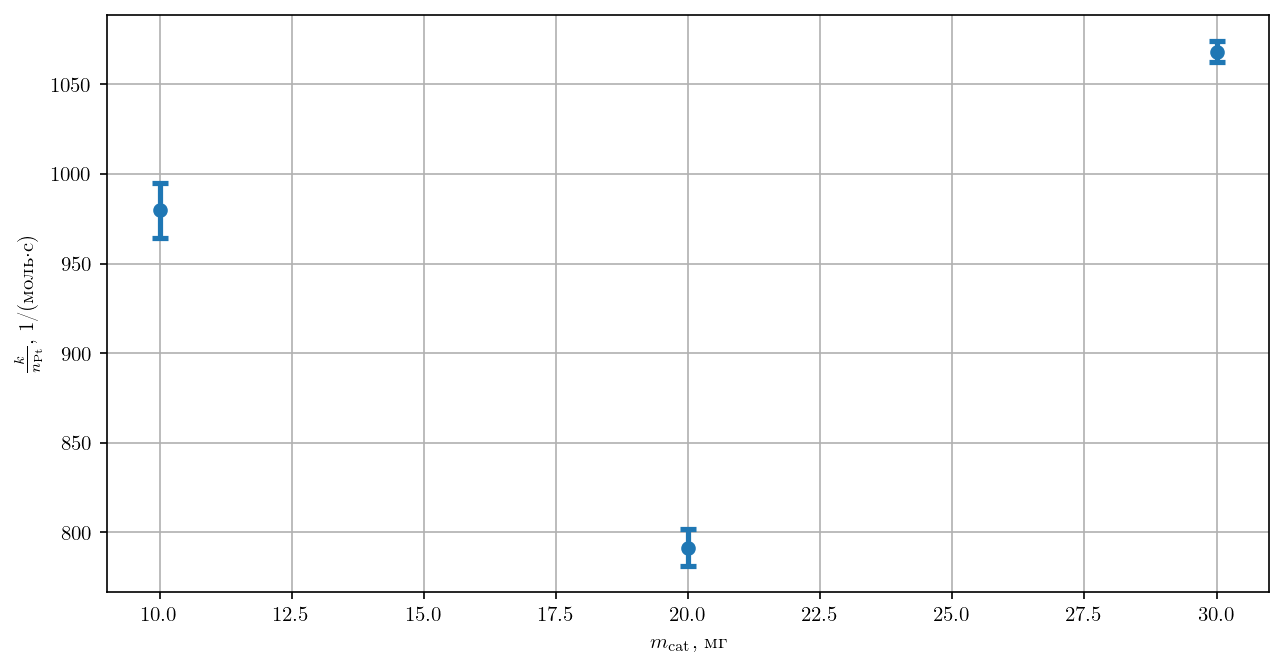

In [19]:
from unc_tools.patches import *

fig, ax = plt.subplots(figsize=(10,5), dpi=150)

DF["k1_n"] = DF.k1 / DF.n

ax.scatter(DF.m*1000, DF.k1_n)
#ax.plot(DF.m/1000, DF.k1_n)
ax.set_xlabel("${m_\\mathrm{cat}}$, мг")
ax.set_ylabel("$\\frac{k}{n_\\mathrm{Pt}}$, 1/(моль$\\cdot$с)")
ax.grid()

DF.to_csv("final.csv")
savefig("final_hetcat2", fig = fig)

DF

print(tabulate(DF, tablefmt = "github", headers =["Масса, г", "й", "k", "a"]))
    

In [15]:
separate_unc(DF).to_csv("final_separate_uncs.csv")

,m,n,k1,k1_n,k2,alpha2
0,0.01,3.434488e-07,0.000336+/-0.000005,980+/-15,(1+/-4)e-06,2.6+/-0.8
1,0.02,6.868977e-07,0.000544+/-0.000007,792+/-10,0.00009+/-0.00015,1.5+/-0.5
2,0.03,1.030347e-06,0.001101+/-0.000006,1068+/-6,0.0010+/-0.0005,1.04+/-0.16


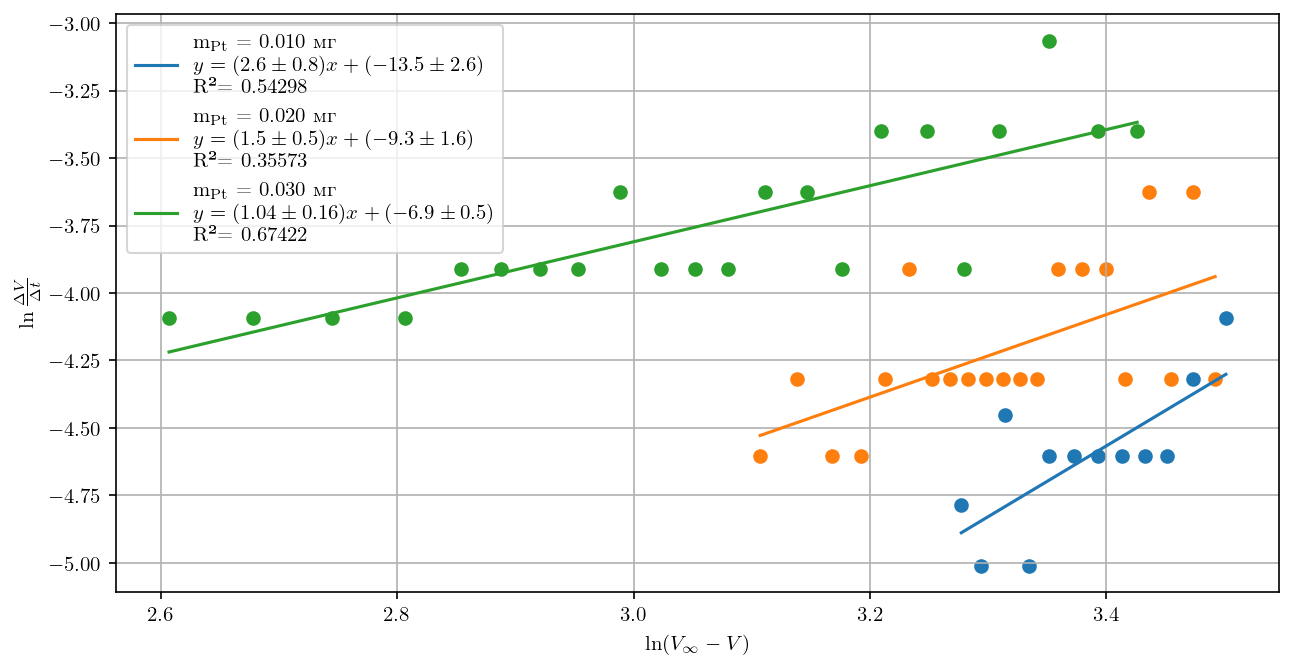

In [16]:
slices = [slice(1,-1), slice(2,-1), slice(1,-1)]

fig, ax = plt.subplots(figsize=(10,5), dpi=150)

k2 = []
alpha2 = []

for i, df_ in enumerate(dfs):
    
    df_ = df_[slices[i]]
    
    df = pd.DataFrame({})
    df["dV"] = df_.V.to_numpy()[1:] - df_.V.to_numpy()[:-1]
    df["dt"] = df_.time.to_numpy()[1:] - df_.time.to_numpy()[:-1]
    df["V"] = (df_.V.to_numpy()[1:] + df_.V.to_numpy()[:-1])/2

    reg = UncRegression(np.log(V_inf - df.V), np.log(df.dV/df.dt))
    k2.append(unc.umath.exp(reg.coefs[1]))
    alpha2.append(reg.coefs[0])
    reg.plot(ax=ax, label =f"m$_\\mathrm{{Pt}}$ = {DF.m[i]:.3f} мг")

DF["k2"] = k2
DF["alpha2"] = alpha2

ax.set_xlabel(r"$\ln (V_\infty - V)$")
ax.set_ylabel(r"$\ln \frac{\Delta V}{\Delta t}$")
savefig("diff_hetcat",fig=fig)

DF

,m,n,k1,k1_n,k2,alpha2,k2_n
0,0.01,3.434488e-07,0.000336+/-0.000005,980+/-15,(1+/-4)e-06,2.6+/-0.8,4+/-10
1,0.02,6.868977e-07,0.000544+/-0.000007,792+/-10,0.00009+/-0.00015,1.5+/-0.5,(1.4+/-2.1)e+02
2,0.03,1.030347e-06,0.001101+/-0.000006,1068+/-6,0.0010+/-0.0005,1.04+/-0.16,(1.0+/-0.5)e+03


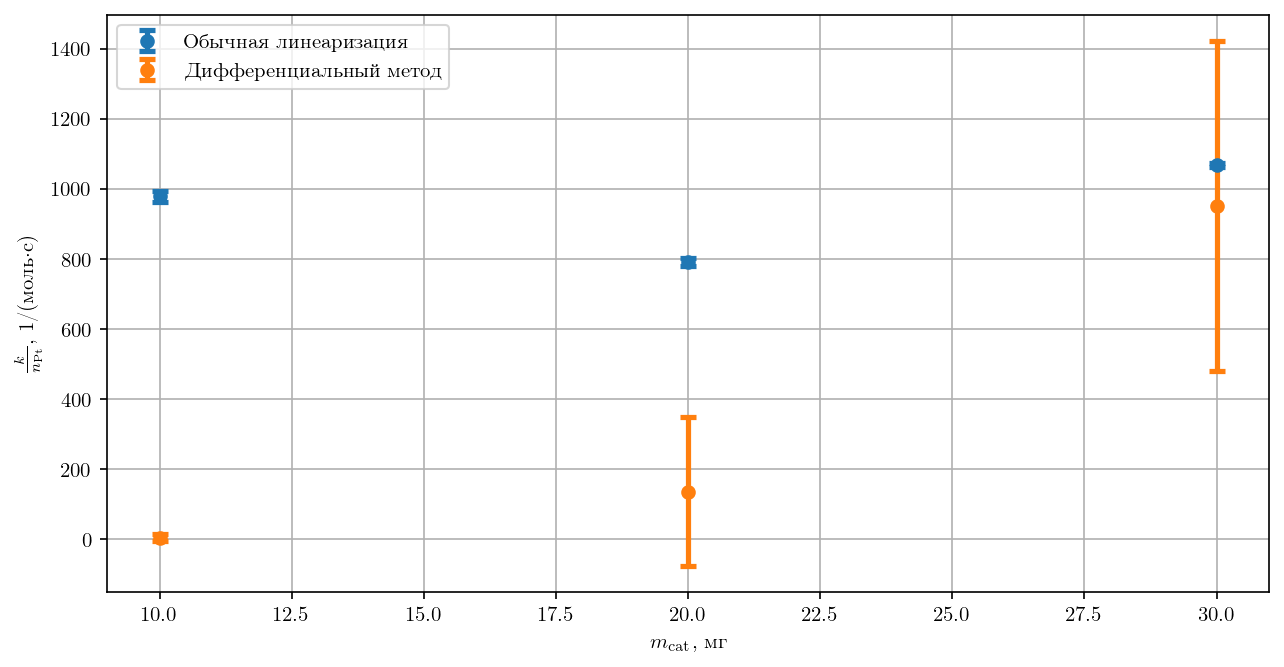

In [20]:
from unc_tools.patches import *

fig, ax = plt.subplots(figsize=(10,5), dpi=150)

DF["k2_n"] = DF.k2 / DF.n

ax.scatter(DF.m*1000, DF.k1_n, label = "Обычная линеаризация")
ax.scatter(DF.m*1000, DF.k2_n, label = "Дифференциальный метод")
ax.set_xlabel("${m_\\mathrm{cat}}$, мг")
ax.set_ylabel("$\\frac{k}{n_\\mathrm{Pt}}$, 1/(моль$\\cdot$с)")
ax.grid()
ax.legend()

savefig("final_hetcat2", fig = fig)

DF

In [18]:
print(tabulate(DF, tablefmt = "github", headers =["Масса, г", "й", "k", "a"]))

|    |      |             |                     | Масса, г   | й                 | k           | a               |
|----|------|-------------|---------------------|------------|-------------------|-------------|-----------------|
|  0 | 0.01 | 3.43449e-07 | 0.000336+/-0.000005 | 980+/-15   | (1+/-4)e-06       | 2.6+/-0.8   | 4+/-10          |
|  1 | 0.02 | 6.86898e-07 | 0.000544+/-0.000007 | 792+/-10   | 0.00009+/-0.00015 | 1.5+/-0.5   | (1.4+/-2.1)e+02 |
|  2 | 0.03 | 1.03035e-06 | 0.001101+/-0.000006 | 1068+/-6   | 0.0010+/-0.0005   | 1.04+/-0.16 | (1.0+/-0.5)e+03 |
